In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# 1. Подготовка данных

In [2]:
df = pd.read_csv ("/datasets/autos.csv")

In [3]:
df, df_test = train_test_split(df, test_size=0.2, random_state=42)

#### разделим исходный датасет на рабочий и проверочный

In [5]:
display(df.shape)
display(df_test.shape)

(283495, 16)

(70874, 16)

In [6]:
df_test.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283495 entries, 107156 to 121958
Data columns (total 16 columns):
DateCrawled          283495 non-null object
Price                283495 non-null int64
VehicleType          253498 non-null object
RegistrationYear     283495 non-null int64
Gearbox              267544 non-null object
Power                283495 non-null int64
Model                267684 non-null object
Kilometer            283495 non-null int64
RegistrationMonth    283495 non-null int64
FuelType             257066 non-null object
Brand                283495 non-null object
NotRepaired          226394 non-null object
DateCreated          283495 non-null object
NumberOfPictures     283495 non-null int64
PostalCode           283495 non-null int64
LastSeen             283495 non-null object
dtypes: int64(7), object(9)
memory usage: 36.8+ MB


In [9]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          29997
RegistrationYear         0
Gearbox              15951
Power                    0
Model                15811
Kilometer                0
RegistrationMonth        0
FuelType             26429
Brand                    0
NotRepaired          57101
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

#### Как видим в датасете много пропущенных значений, которые следует обработать.

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,283495.000000,283495.000000,283495.000000,283495.000000,283495.000000,283495.0,283495.000000
mean,4406.829461,2004.327963,109.727692,128250.339512,5.710827,0.0,50494.489458
std,4505.093187,93.281850,179.875514,37860.210427,3.727439,0.0,25788.220471
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,68.000000,125000.000000,3.000000,0.0,30163.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49377.000000
75%,6399.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### Глядя на значения средних и медиан можно с уверенностью сказать, что в датасете есть выбросы, какие именно нам скажут графики при дальнейшем изучении.

In [11]:
# сразу приведем столбцы DateCrawled, DateCreated, LastSeen к типу datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y.%m.%d %H:%M:%S')
df_test['DateCreated'] = pd.to_datetime(df_test['DateCreated'], format='%Y.%m.%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y.%m.%d')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y.%m.%d %H:%M:%S')

In [12]:
df.duplicated().sum()

2

In [13]:
df.drop_duplicates().reset_index(drop = True, inplace = True)

#### сразу удалим дублирующие строки и приступим к изучению графиков

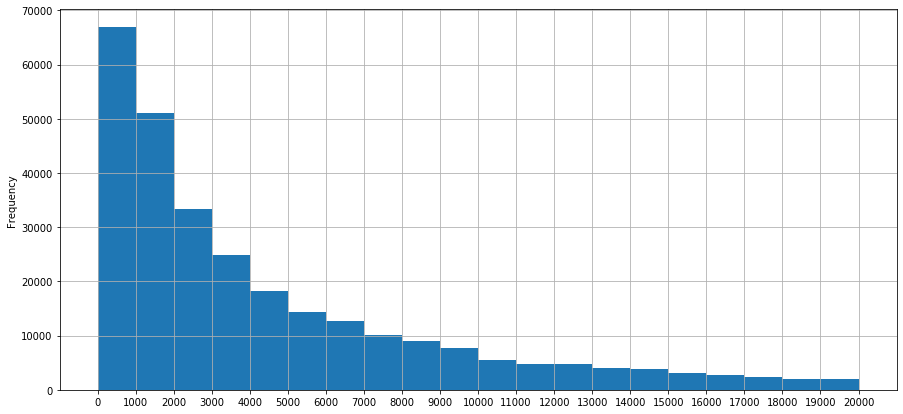

In [14]:
df['Price'].plot(kind='hist', bins=20, figsize= (15, 7), xticks = (range (0, 21000, 1000)), grid=True)

#### Очень много цен находятся в границах от 0 до 1000.

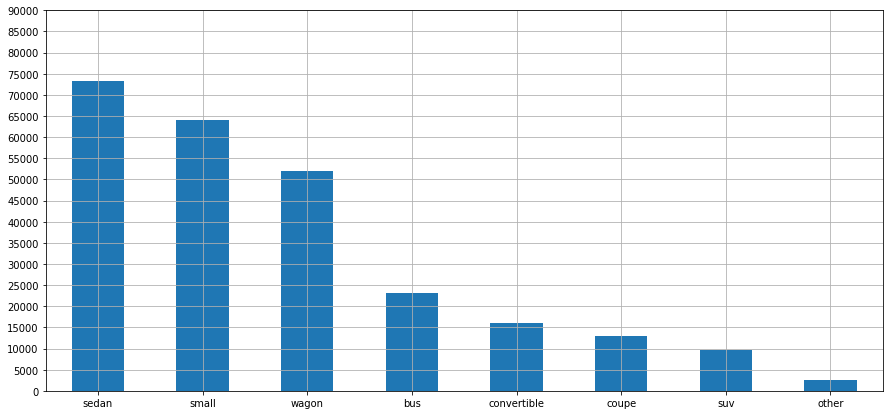

In [15]:
df['VehicleType'].value_counts().plot(kind="bar", figsize= (15, 7), rot = 0, grid=True, yticks = (range (0, 95000, 5000)))

#### Ничего необычного, что делать с пропусками решим когда изучим все графики.

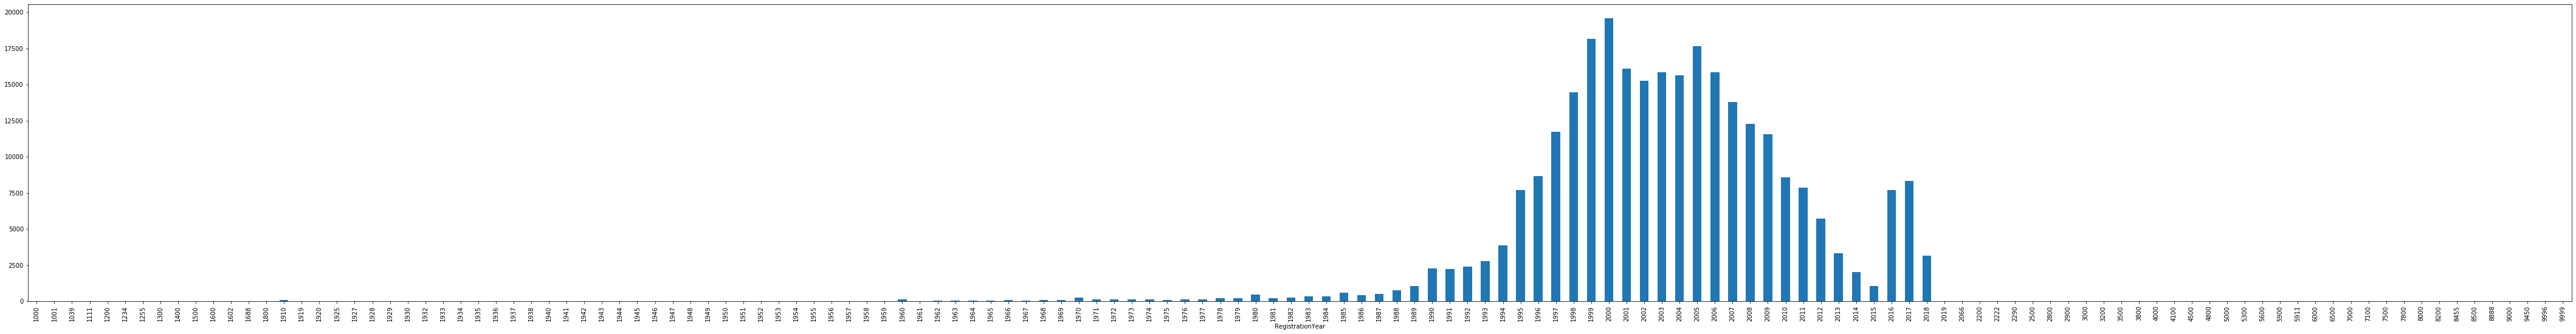

In [16]:
df.groupby(by='RegistrationYear')['Price'].count().plot(kind='bar', figsize= (75, 9))

#### Очень много выбросов. Посмотрим сколько значений лежит в диапазоне от 1980 до 2018 года

In [17]:
df.query('1980 <= RegistrationYear <= 2018')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
107156,2016-03-17 15:47:14,16780,suv,2009,manual,140,tiguan,90000,3,gasoline,volkswagen,yes,2016-03-17,0,41069,2016-04-06 23:45:20
20206,2016-03-14 19:36:43,9100,coupe,1987,manual,160,other,150000,9,petrol,porsche,no,2016-03-14,0,23826,2016-04-06 04:17:19
323736,2016-03-17 14:52:09,2500,convertible,2001,manual,147,astra,150000,6,petrol,opel,no,2016-03-17,0,52531,2016-04-06 21:17:48
233344,2016-03-21 16:45:33,600,NaN,2000,manual,193,5er,150000,0,NaN,bmw,NaN,2016-03-21,0,26607,2016-03-21 16:45:33
112072,2016-03-25 20:52:37,12790,sedan,2012,manual,150,civic,70000,3,gasoline,honda,no,2016-03-25,0,44319,2016-04-07 03:46:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,2016-03-20 13:42:09,200,small,1998,manual,50,polo,150000,10,petrol,volkswagen,yes,2016-03-20,0,35099,2016-04-06 14:44:24
259178,2016-04-02 00:47:21,4690,NaN,2017,manual,105,astra,125000,8,petrol,opel,no,2016-04-01,0,9526,2016-04-06 04:16:31
131932,2016-03-27 17:52:44,12525,sedan,2004,manual,192,5er,150000,6,petrol,bmw,no,2016-03-27,0,90530,2016-04-05 14:16:22
146867,2016-03-22 05:36:17,4444,sedan,2004,manual,150,3er,150000,2,gasoline,bmw,no,2016-03-22,0,51069,2016-03-22 08:46:23


#### 99% значений лежит в этом диапазоне. Остальное будем удалять.

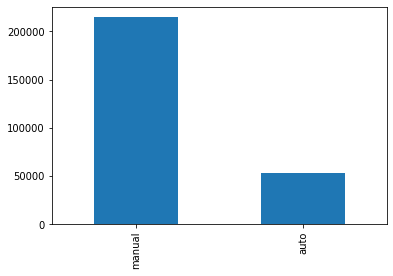

In [18]:
df['Gearbox'].value_counts().plot(kind="bar")

#### Ничего необычного, что делать с пропусками решим когда изучим все графики.

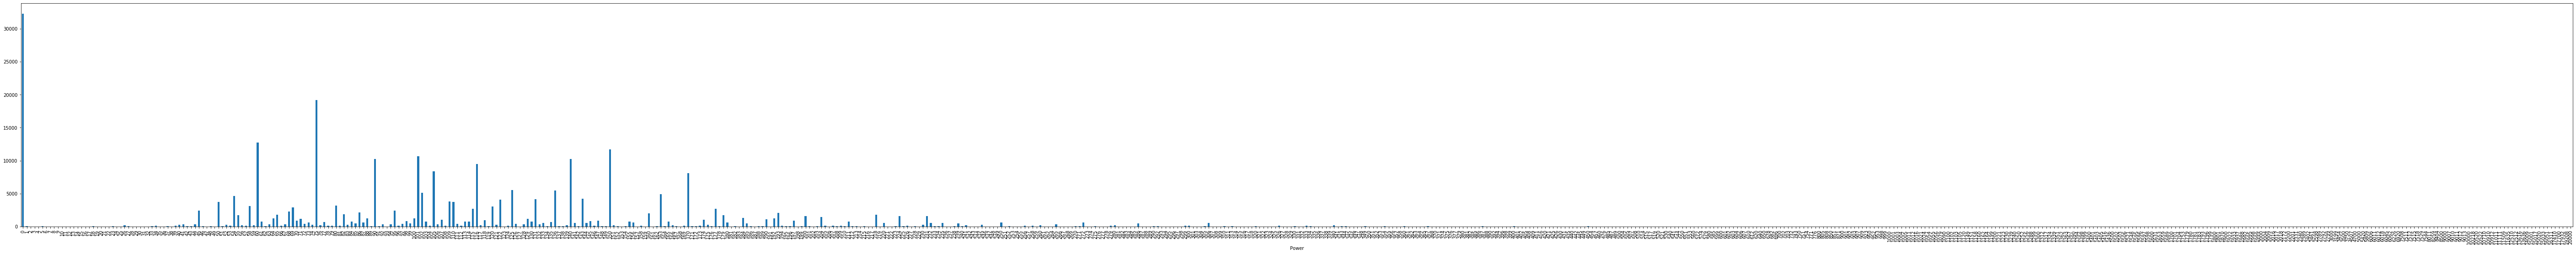

In [19]:
df.groupby(by='Power')['Price'].count().plot(kind='bar', figsize= (100, 9))

In [20]:
gh = pd.DataFrame(df.groupby(by='Power')['Price'].count()).reset_index ()
gh.columns = ['power', "count"]

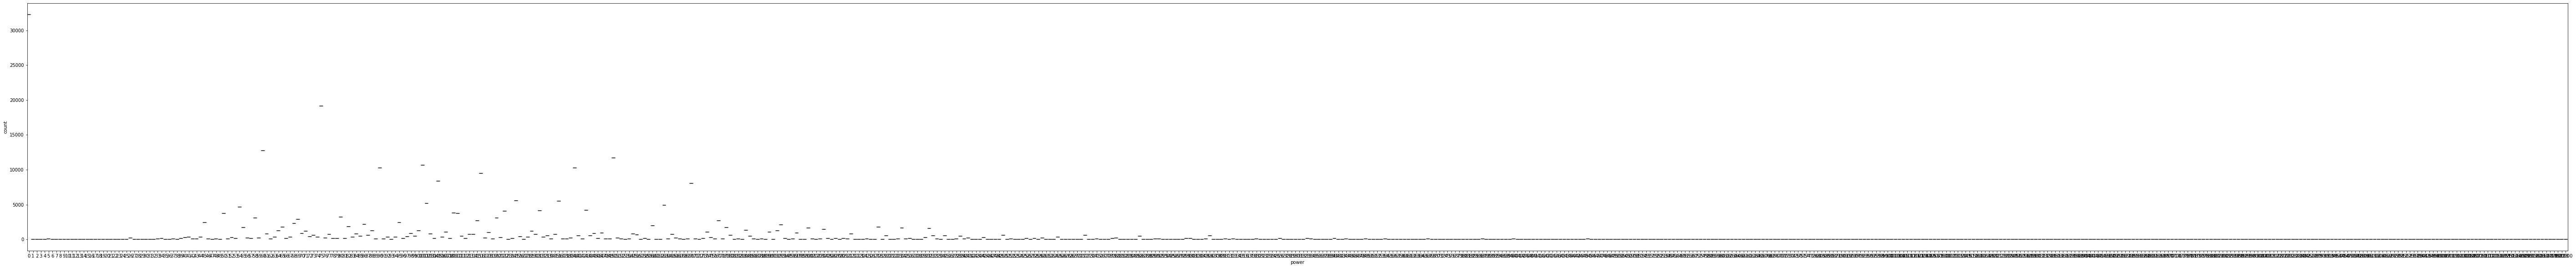

In [21]:
fig, ax = plt.subplots(figsize=(100, 10))
sns.boxplot(data=gh, x='power', y='count', orient = "v", ax=ax, )

#### График очень большой и с ним трудно работать, но по нему видно огромное количество вбросов, попробуем выбрать диапазон вменяемых значений л.с.

In [22]:
power = df.groupby(by='Power')['Price'].count()
power = pd.DataFrame(data = power)
display(power)

,Price
Power,
0,32270
1,30
2,9
3,8
4,23
...,...
17410,1
17700,1
17932,1


#### 40225 нулевых значений мощности, абсолютно невменяемые значения в 20000 л.с., все это не поможет нашим моделям качественно обучиться, выберем порог, где вхождения меньше определенного нами количества автоматически отбросятся.

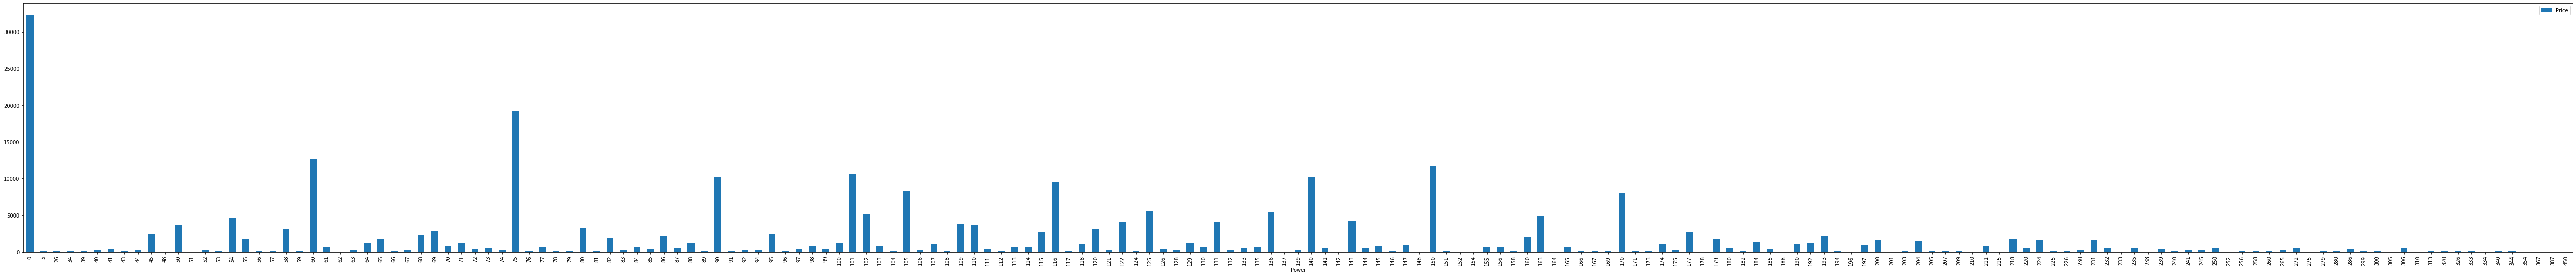

In [23]:
power = power.query('Price > 50')
power.plot(kind='bar', figsize= (90, 9))

In [24]:
display(df.query('Power == 5').head(2))
display(df.query('Power == 18').head(2))
display(df.query('Power == 26').head(2))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
133797,2016-04-01 11:57:07,15990,other,2016,auto,5,NaN,5000,4,gasoline,sonstige_autos,no,2016-04-01,0,19288,2016-04-07 08:46:09
30097,2016-03-24 22:52:33,6850,small,2012,auto,5,NaN,30000,4,gasoline,sonstige_autos,no,2016-03-24,0,24784,2016-04-06 02:17:41


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
48364,2016-03-08 20:52:27,800,small,1971,manual,18,500,80000,4,petrol,fiat,yes,2016-03-08,0,76829,2016-03-09 12:46:17
68185,2016-03-25 14:48:15,19900,convertible,1932,manual,18,other,5000,2,petrol,bmw,no,2016-03-25,0,99735,2016-04-06 18:15:26


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
233439,2016-03-20 16:57:18,0,sedan,1989,manual,26,601,100000,7,petrol,trabant,no,2016-03-20,0,18337,2016-03-24 09:45:40
21468,2016-03-27 15:39:31,4800,sedan,1988,manual,26,601,40000,4,petrol,trabant,no,2016-03-27,0,74363,2016-04-07 12:17:58


####  Остались еще подозрительные значения мощностей авто (например 5 л.с.) н ок ним мы вернемся чуть позже, когда дойдем до брендов автомобилей.

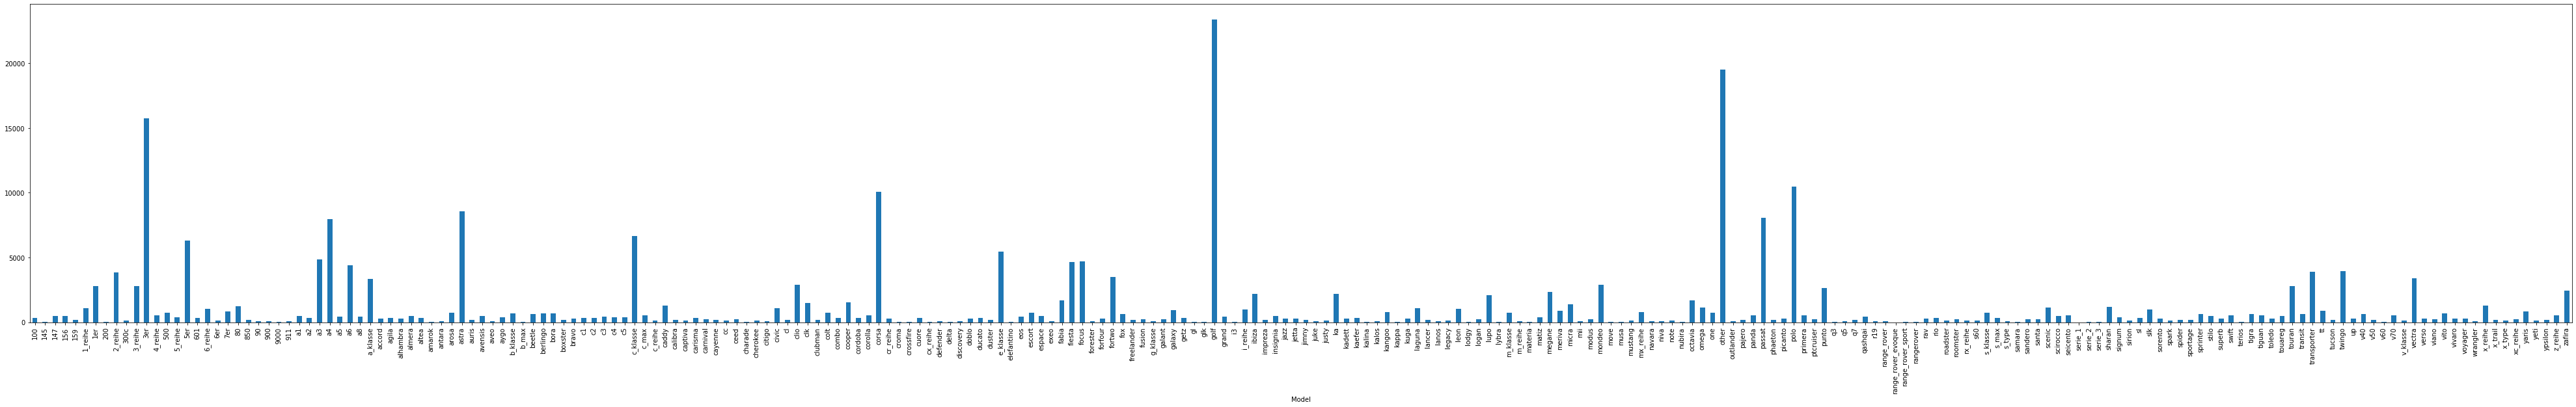

In [25]:
df.groupby(by='Model')['Price'].count().plot(kind='bar', figsize= (70, 9))

#### За исключение пропусков все впорядке.

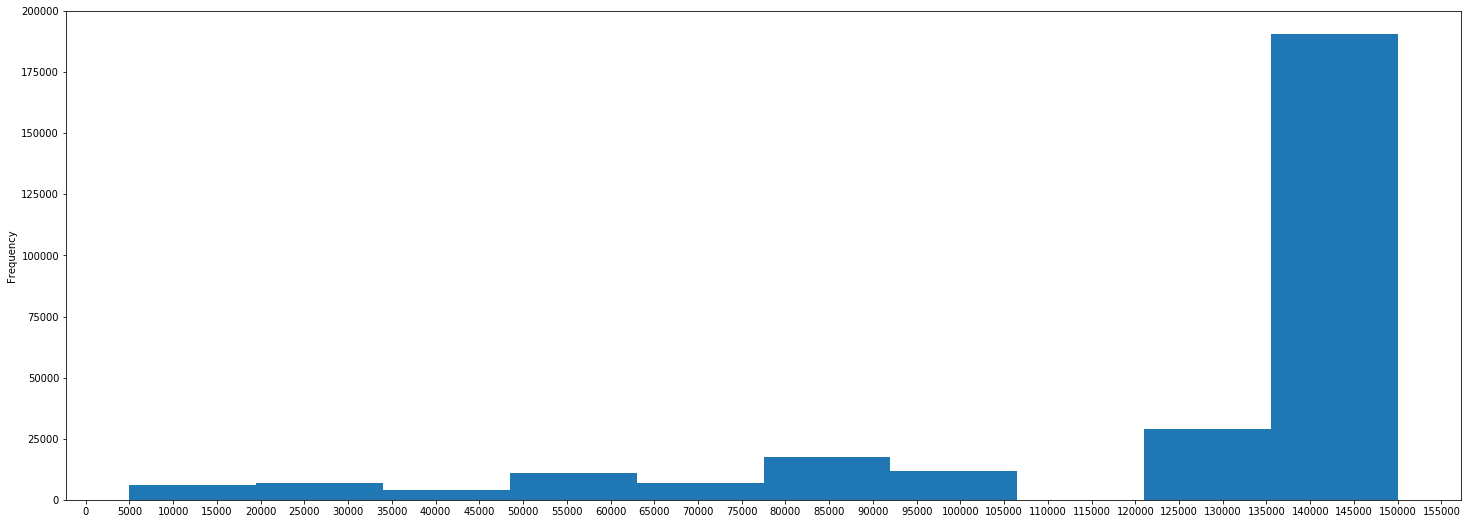

In [26]:
df['Kilometer'].plot(kind='hist', figsize= (25, 9), xticks=range(0, 160000, 5000))

#### пробеги автомобилей без вбросов, ничего необычного, двигаемся дальше.

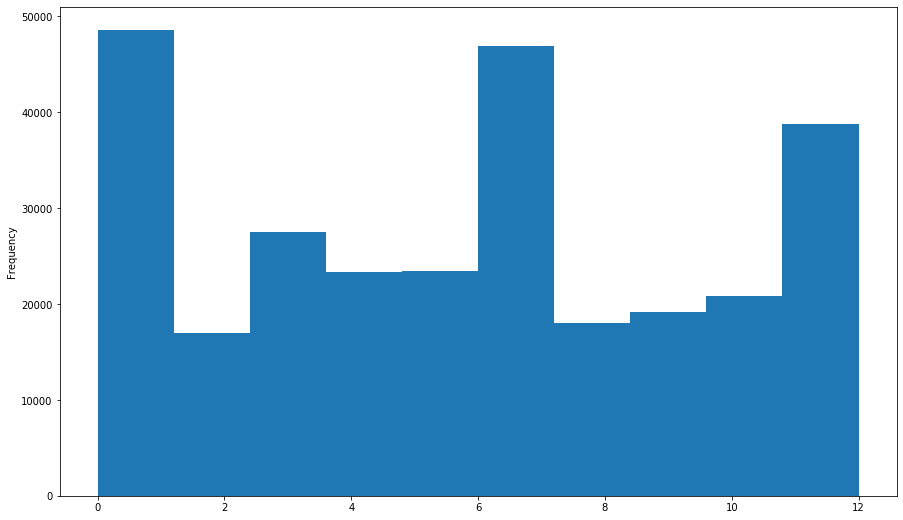

In [27]:
df['RegistrationMonth'].plot(kind='hist', figsize= (15, 9))

#### Не понятно значение 0 месяца регистрации, но в остальном все в порядке, однако для модели эта графа врятли несет в себе полезную информацию.

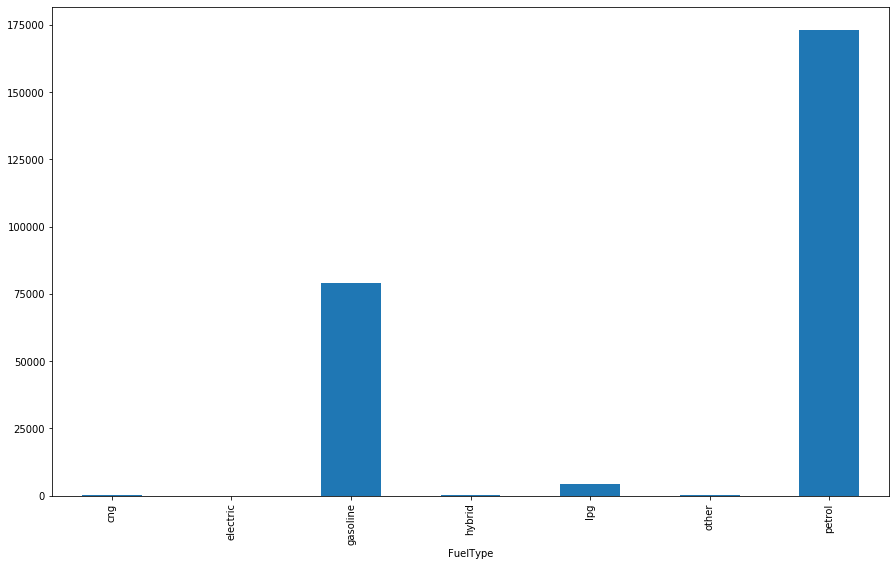

In [28]:
df.groupby(by='FuelType')['Price'].count().plot(kind='bar', figsize= (15, 9))

In [29]:
df.query('FuelType == "other"').head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
68585,2016-03-05 22:51:48,0,wagon,2016,manual,0,other,5000,5,other,mini,NaN,2016-03-05,0,73262,2016-04-07 03:46:16
24321,2016-03-10 11:55:03,4800,suv,1966,manual,50,other,60000,3,other,audi,no,2016-03-10,0,29348,2016-03-15 01:16:25
175423,2016-03-14 18:45:09,2700,other,1975,manual,26,NaN,40000,5,other,trabant,no,2016-03-14,0,8485,2016-04-04 01:45:04
80768,2016-03-12 17:49:25,4000,sedan,2005,manual,105,astra,150000,4,other,opel,no,2016-03-12,0,53879,2016-03-17 20:48:39
285045,2016-03-05 16:54:33,0,sedan,1983,manual,26,601,20000,9,other,trabant,no,2016-03-05,0,29549,2016-03-06 04:16:16


#### В целом график выглядит нормально. cng и lpg это автомобили на газу. В категории прочее снова мелькает sonstige_autos, до которого мы вскоре дойдем и обработку данных начнем именно с него.

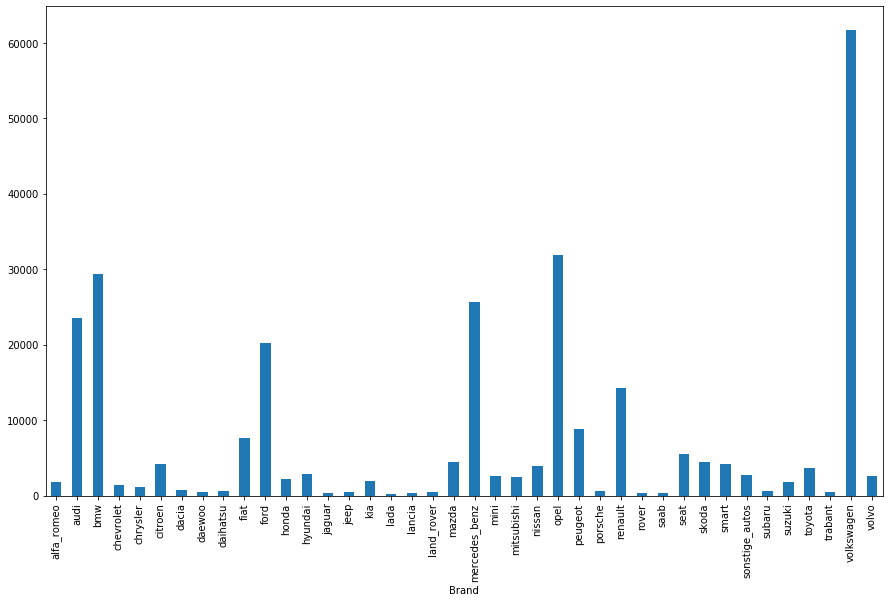

In [30]:
df.groupby(by='Brand')['Price'].count().plot(kind='bar', figsize= (15, 9))

In [31]:
# В глаза сразу бросается странный брэнд автомобилей, не знакомый мне до этого момента.
df.query("Price < 1000 and Model.isnull()")
# Как говорит гугл sonstige_autos это модельки машин, поэтому без сожаления удаляем эти вбросы из нашего датасета
display(df.query('Brand == "sonstige_autos"'))
df = df.query('Brand != "sonstige_autos"').reset_index(drop=True)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
81744,2016-03-23 14:50:32,2400,wagon,1985,manual,50,NaN,80000,10,petrol,sonstige_autos,no,2016-03-23,0,99885,2016-04-05 17:21:32
237691,2016-03-27 15:52:11,950,NaN,2015,auto,12,NaN,5000,0,petrol,sonstige_autos,NaN,2016-03-27,0,26607,2016-04-07 14:32:22
148775,2016-03-22 21:57:46,4500,bus,1996,auto,230,NaN,150000,2,lpg,sonstige_autos,yes,2016-03-22,0,52538,2016-04-04 17:47:49
192225,2016-03-25 18:52:03,250,NaN,2017,NaN,0,NaN,150000,12,petrol,sonstige_autos,NaN,2016-03-25,0,31135,2016-03-25 18:52:03
343320,2016-04-04 11:45:18,10500,sedan,1975,manual,83,NaN,30000,6,petrol,sonstige_autos,no,2016-04-04,0,14195,2016-04-06 12:44:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20159,2016-04-01 21:57:05,1600,NaN,4100,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-01,0,67686,2016-04-05 20:19:27
14397,2016-04-01 18:48:57,8500,bus,2011,manual,136,NaN,150000,5,cng,sonstige_autos,no,2016-04-01,0,25569,2016-04-01 18:48:57
201163,2016-03-26 13:52:46,6900,NaN,2016,manual,70,NaN,40000,12,petrol,sonstige_autos,no,2016-03-26,0,52072,2016-04-06 02:17:11
86416,2016-04-01 19:57:10,0,NaN,1990,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-04-01,0,27749,2016-04-01 19:57:10


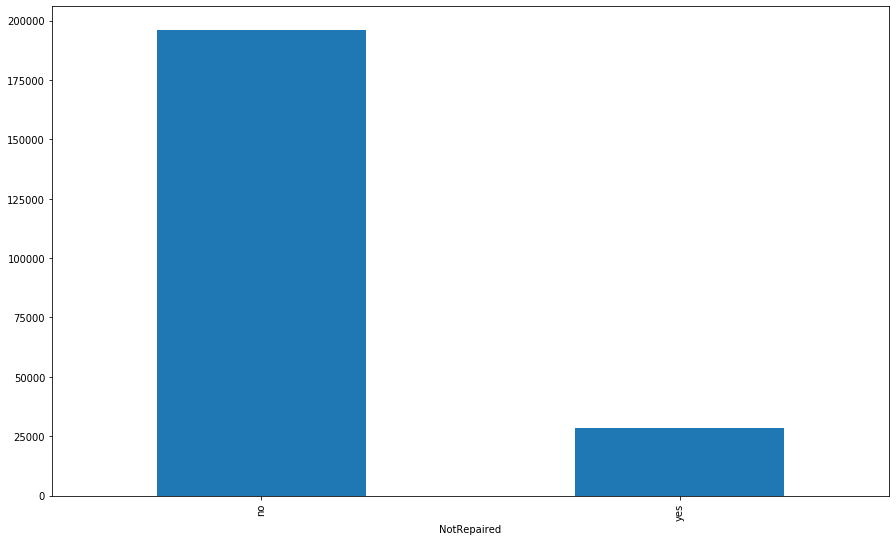

In [32]:
df.groupby(by='NotRepaired')['Price'].count().plot(kind='bar', figsize= (15, 9))

In [33]:
df.query('NotRepaired.isnull() and Price > 100').sort_values(by="Price").head(1)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
108001,2016-03-16 13:53:08,105,NaN,2010,NaN,0,q7,125000,0,NaN,audi,NaN,2016-03-16,0,27753,2016-03-24 04:15:39


#### Логично предположить, что пропущенные значения этого столбца означают, что машина не была в ремонте, но в глаза сразу же бросаются объявления, где, например, audi Q7 2010 года стоит 105 евро, что явно свидетельствует о том, что это тотал (разбитая машина не подлежащая восстановлению). 

In [34]:
print("Нулевых значений:", df['NumberOfPictures'].isnull().sum())
print("Распределение по количеству фотографий", df['NumberOfPictures'].value_counts())

Нулевых значений: 0
Распределение по количеству фотографий 0    280811
Name: NumberOfPictures, dtype: int64


# 1.1. Обработка данных

In [35]:
df.drop('NumberOfPictures', axis=1, inplace=True)
df.drop('PostalCode', axis=1, inplace=True)
df.drop('LastSeen', axis=1, inplace=True)
df.drop('DateCrawled', axis=1, inplace=True)
df.drop('RegistrationMonth', axis=1, inplace=True)

df_test.drop('NumberOfPictures', axis=1, inplace=True)
df_test.drop('PostalCode', axis=1, inplace=True)
df_test.drop('LastSeen', axis=1, inplace=True)
df_test.drop('DateCrawled', axis=1, inplace=True)
df_test.drop('RegistrationMonth', axis=1, inplace=True)

#### Эти столбцы не несут в себе никакой полезной информации для модели.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280811 entries, 0 to 280810
Data columns (total 11 columns):
Price               280811 non-null int64
VehicleType         251632 non-null object
RegistrationYear    280811 non-null int64
Gearbox             265725 non-null object
Power               280811 non-null int64
Model               267684 non-null object
Kilometer           280811 non-null int64
FuelType            255249 non-null object
Brand               280811 non-null object
NotRepaired         224761 non-null object
DateCreated         280811 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 23.6+ MB


In [37]:
# удалим выбросы по годам производства
df = df.query('1980 <= RegistrationYear <= 2018').reset_index(drop=True)

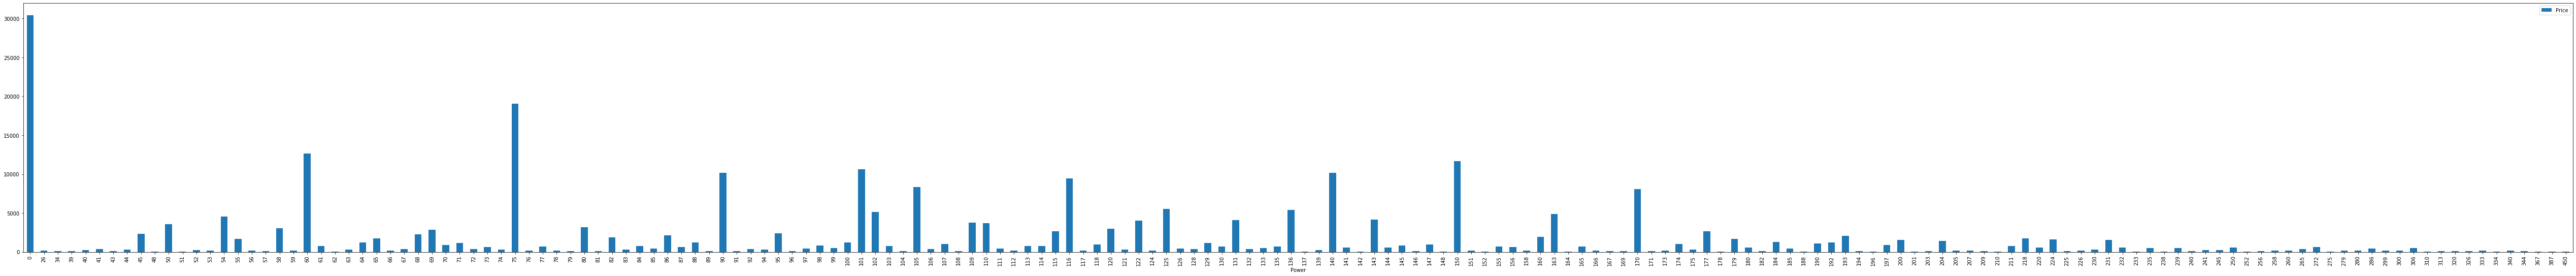

In [38]:
# Еще раз создадим сгруппированый по мощности датафрейм и посмотрим как изменилось распределение после удаления моделек авто.
power = df.groupby(by='Power')['Price'].count()
power = pd.DataFrame(data = power)
power = power.query('Price > 50')
power.plot(kind='bar', figsize= (90, 9))

In [39]:
df = df.query('Power != 0').reset_index(drop=True)

#### как видим теперь из выбросов остались только нулевые значения, удалим их из датафрейма.

In [40]:
money = pd.DataFrame(df.groupby(by="Price")['Price'].count())
money.columns = ['count']

In [41]:
money.query("count > 50").sort_values(by='Price').head(15)

,count
Price,
0,5356
1,534
50,119
80,57
100,490
120,110
150,858
180,141
190,54


In [42]:
df = df.query('Price >= 100').reset_index(drop=True)

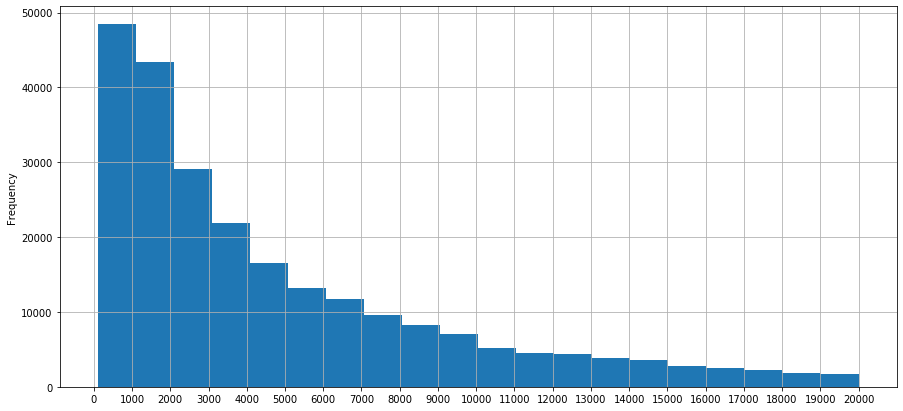

In [43]:
df['Price'].plot(kind='hist', bins=20, figsize= (15, 7), xticks = (range (0, 21000, 1000)), grid=True)

#### Как видно ближайший скачек количества машин - 100 евро. Думаю в данном случае можно считать это минимальной планкой и все объявления с ценой ниже признать выбросами и удалить.

In [44]:
df.isnull().sum()

Price                   0
VehicleType         16760
RegistrationYear        0
Gearbox              4724
Power                   0
Model                8349
Kilometer               0
FuelType            15538
Brand                   0
NotRepaired         36990
DateCreated             0
dtype: int64

In [45]:
df_drop = df.copy()

#### создаем копию датасета, где просто удалим все пропуски и, для сравнения, обучим модель на нем

In [48]:
# Заполнение Model
car_model = pd.DataFrame(df.groupby(by='Brand')['Model'].value_counts())
car_model.columns = ['count']
car_model = pd.DataFrame(car_model['count'].sort_values(ascending=False)).reset_index()
for i in car_model['Brand'].unique():
    maximum = car_model[car_model['Brand'] == i]['count'].max()
    model = car_model.query('count == @maximum and Brand == @i')['Model'].reset_index(drop=True)
    df.loc[df['Brand'] == i, 'Model'] = df.loc[df['Brand'] == i, 'Model'].fillna(model[0])

In [49]:
# Заполнение VehicleType
car_model = pd.DataFrame(df.groupby(by='Model')['VehicleType'].value_counts())
car_model.columns = ['count']
car_model = pd.DataFrame(car_model['count'].sort_values(ascending=False)).reset_index()
for i in car_model['Model'].unique():
    maximum = car_model[car_model['Model'] == i]['count'].max()
    model = car_model.query('count == @maximum and Model == @i')['VehicleType'].reset_index(drop=True)
    df.loc[df['Model'] == i, 'VehicleType'] = df.loc[df['Model'] == i, 'VehicleType'].fillna(model[0])

In [50]:
# Заполнение Gearbox
car_model = pd.DataFrame(df.groupby(by='Model')['Gearbox'].value_counts())
car_model.columns = ['count']
car_model = pd.DataFrame(car_model['count'].sort_values(ascending=False)).reset_index()
for i in car_model['Model'].unique():
    maximum = car_model[car_model['Model'] == i]['count'].max()
    model = car_model.query('count == @maximum and Model == @i')['Gearbox'].reset_index(drop=True)
    df.loc[df['Model'] == i, 'Gearbox'] = df.loc[df['Model'] == i, 'Gearbox'].fillna(model[0])

In [51]:
# Заполнение FuelType
car_model = pd.DataFrame(df.groupby(by='Model')['FuelType'].value_counts())
car_model.columns = ['count']
car_model = pd.DataFrame(car_model['count'].sort_values(ascending=False)).reset_index()
for i in car_model['Model'].unique():
    maximum = car_model[car_model['Model'] == i]['count'].max()
    model = car_model.query('count == @maximum and Model == @i')['FuelType'].reset_index(drop=True)
    df.loc[df['Model'] == i, 'FuelType'] = df.loc[df['Model'] == i, 'FuelType'].fillna(model[0])

In [52]:
# заполнение NotRepaired
df_repair = df.copy()
df_repair.dropna(inplace=True)
encoder = OrdinalEncoder()
df_repair =  pd.DataFrame(encoder.fit_transform(df_repair), columns=df_repair.columns)

X = df_repair.drop('NotRepaired', axis=1)
y = df_repair['NotRepaired']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

lgbm = LGBMClassifier (
    boosting_type='gbdt',
    random_state=42    
)

lgbm.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

pred = lgbm.predict(X_test)

pred = pd.DataFrame(pred)
pred['y'] = y_test
print("Среднее реальное:", pred['y'].mean())
pred['y'] = pred['y'].fillna(0)
print("Среднее если забить пропуски нулями:", pred['y'].mean())
print("Среднее по предсказаниям:", pred[0].mean())

# модель просто заполнила все нулями.

Среднее реальное: 0.11311868997783797
Среднее если забить пропуски нулями: 0.044859744635140746
Среднее по предсказаниям: 0.045067259100119626


In [53]:
fd = df.copy()

In [54]:
fd.fillna('no', inplace=True)

Пропуски заполнили и после этого модели стали хуже предсказывать стоимость автомобиля, не сильно, но всеже.
К примеру CatBoost Regressor скатился с 274.975 до 310.952  
    Предлагаю все-же удалить все NaNы

In [88]:
df_drop.dropna(inplace=True)
df_drop.reset_index(inplace=True, drop=True)
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184980 entries, 0 to 184979
Data columns (total 11 columns):
Price               184980 non-null float64
VehicleType         184980 non-null float64
RegistrationYear    184980 non-null float64
Gearbox             184980 non-null float64
Power               184980 non-null float64
Model               184980 non-null float64
Kilometer           184980 non-null float64
FuelType            184980 non-null float64
Brand               184980 non-null float64
NotRepaired         184980 non-null float64
DateCreated         184980 non-null float64
dtypes: float64(11)
memory usage: 15.5 MB


# 2. Обучение моделей

## 2.1. CatBoost Regressor

## 2.1.1 CatBoost Regressor БЕЗ КОДИРОВАНИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

In [56]:
X = fd.drop('Price', axis=1)
y = fd['Price']
df_test_features = df_test.drop('Price', axis=1)
df_test_target = df_test['Price']
df_drop_features = df_drop.drop('Price', axis=1)
df_drop_target = df_drop['Price']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(df_drop_features, 
                                                                        df_drop_target, 
                                                                        test_size=0.4, 
                                                                        random_state=42)

In [58]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [59]:
catboost_model = CatBoostRegressor (
                            random_state=42, 
                            iterations=700, 
                            verbose=350, 
                            learning_rate=0.1 
                            )
catboost_drop = CatBoostRegressor (
                            random_state=42, 
                            iterations=700, 
                            verbose=350, 
                            learning_rate=0.1 
                            )

In [60]:
%%time
catboost_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test), use_best_model=True)
catboost_drop.fit(X_train_drop, y_train_drop, cat_features=cat_features, eval_set = (X_test_drop, y_test_drop), 
                                                                                             use_best_model=True)

0:	learn: 4266.8079366	test: 4254.2718360	best: 4254.2718360 (0)	total: 711ms	remaining: 8m 17s
350:	learn: 1593.9972956	test: 1623.6635195	best: 1623.6635195 (350)	total: 2m 46s	remaining: 2m 45s
699:	learn: 1530.1619137	test: 1587.0392443	best: 1587.0392443 (699)	total: 5m 38s	remaining: 0us

bestTest = 1587.039244
bestIteration = 699

0:	learn: 4385.8105530	test: 4399.4330866	best: 4399.4330866 (0)	total: 455ms	remaining: 5m 18s
350:	learn: 1552.4580020	test: 1612.2220065	best: 1612.2220065 (350)	total: 2m 11s	remaining: 2m 10s
699:	learn: 1486.2575154	test: 1576.2902293	best: 1576.2902293 (699)	total: 4m 19s	remaining: 0us

bestTest = 1576.290229
bestIteration = 699

CPU times: user 8min 57s, sys: 1min 5s, total: 10min 2s
Wall time: 10min 12s


In [61]:
%%time
pred = catboost_model.predict(X_test)
pred_test = catboost_model.predict(df_test_features)
pred_drop = catboost_drop.predict(df_test_features)

CPU times: user 2.05 s, sys: 95.5 ms, total: 2.14 s
Wall time: 2.1 s


In [62]:
print("RMSE на валидационной выборке:", mean_squared_error (y_test, pred)**0.5)
print("RMSE на тестовой выборке с заполнением NaN'ов:", mean_squared_error (df_test_target, pred_test)**0.5)
print("RMSE на тестовой выборке с дропнутыми NaN:", mean_squared_error (df_test_target, pred_drop)**0.5)

RMSE на валидационной выборке: 1587.039244325458
RMSE на тестовой выборке с заполнением NaN'ов: 1747.1886654729453
RMSE на тестовой выборке с дропнутыми NaN: 1719.1656933353454


#### Catboost обучился на 700 итерациях с минимизацией функции потерь RMSE (что и требуется из условий задания), результаты представлены в коде выше.

## 2.1.2 CatBoost Regressor C КОДИРОВАНИЕМ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

In [63]:
dfoe = fd.copy()
df_test_oe = df_test.copy()

In [64]:
encoder = OrdinalEncoder()

In [65]:
dfoe =  pd.DataFrame(encoder.fit_transform(dfoe), columns=dfoe.columns)
df_test_oe = pd.DataFrame(encoder.fit_transform(df_test_oe), columns=df_test_oe.columns)
df_drop = pd.DataFrame(encoder.fit_transform(df_drop), columns=df_drop.columns)

In [66]:
X = dfoe.drop('Price', axis=1)
y = dfoe['Price']
X_df_test = df_test_oe.drop('Price', axis=1)
y_df_test = df_test_oe['Price']
X_drop = df_drop.drop('Price', axis=1)
y_drop = df_drop['Price']

In [67]:
X_train_oe, X_test_oe, y_train_oe, y_test_oe = train_test_split(X, y, test_size=0.4, random_state=42)
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size=0.4, random_state=42)

In [68]:
catboost = CatBoostRegressor (
                            random_state=42, 
                            iterations=700, 
                            verbose=350, 
                            learning_rate=0.1 
                            )
catboost_drop = catboost.copy()

In [69]:
%%time
catboost.fit(X_train_oe, y_train_oe, eval_set = (X_test_oe, y_test_oe), use_best_model=True)
catboost_drop.fit(X_train_drop, y_train_drop, eval_set = (X_test_drop, y_test_drop), use_best_model=True)

0:	learn: 780.3243784	test: 778.6711335	best: 778.6711335 (0)	total: 96.7ms	remaining: 1m 7s
350:	learn: 288.5597258	test: 293.8558846	best: 293.8558846 (350)	total: 44.7s	remaining: 44.4s
699:	learn: 276.6329513	test: 286.4389541	best: 286.4389541 (699)	total: 1m 28s	remaining: 0us

bestTest = 286.4389541
bestIteration = 699

0:	learn: 733.9082344	test: 735.2386835	best: 735.2386835 (0)	total: 74.4ms	remaining: 52s
350:	learn: 251.6792739	test: 259.9156260	best: 259.9156260 (350)	total: 35.9s	remaining: 35.7s
699:	learn: 240.4896893	test: 253.3141738	best: 253.3141738 (699)	total: 1m 11s	remaining: 0us

bestTest = 253.3141738
bestIteration = 699

CPU times: user 2min 23s, sys: 17.9 s, total: 2min 41s
Wall time: 2min 51s


In [70]:
%%time
pred = catboost.predict(X_test_oe)
pred_test = catboost.predict(X_df_test)
pred_drop = catboost_drop.predict(X_df_test)

CPU times: user 369 ms, sys: 1.13 ms, total: 370 ms
Wall time: 344 ms


In [71]:
print("RMSE на валидационной выборке:", mean_squared_error (y_test_oe, pred)**0.5)
print("RMSE на тестовой выборке с заполнением NaN'ов:", mean_squared_error (y_df_test, pred_test)**0.5)
print("RMSE на тестовой выборке с дропнутыми NaN:", mean_squared_error (y_df_test, pred_drop)**0.5)

RMSE на валидационной выборке: 286.4389541199551
RMSE на тестовой выборке с заполнением NaN'ов: 739.0222973956279
RMSE на тестовой выборке с дропнутыми NaN: 824.5246244516567


#### После кодирования категориальных  признаков CatBoost показал лучший результат, чем когда он кодировал признаки сам.

## 2.2. XGBoost Regressor

In [72]:
xgb = XGBRegressor (
                    random_state=42, 
                    verbosity=1, 
                    n_jobs=-1, 
                    )
xgb_drop =  XGBRegressor (
                    random_state=42, 
                    verbosity=1, 
                    n_jobs=-1, 
                    )

In [73]:
%%time
xgb.fit(X_train_oe, y_train_oe)
xgb_drop.fit(X_train_drop, y_train_drop)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 39.3 s, sys: 0 ns, total: 39.3 s
Wall time: 39.7 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [74]:
%%time
pred = xgb.predict(X_test_oe)
pred_test = xgb.predict(X_df_test)
pred_drop = xgb_drop.predict(X_df_test)

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.09 s


In [75]:
print("RMSE на валидационной выборке:", mean_squared_error (y_test_oe, pred)**0.5)
print("RMSE на тестовой выборке с заполнением NaN'ов:", mean_squared_error (y_df_test, pred_test)**0.5)
print("RMSE на тестовой выборке с дропнутыми NaN:", mean_squared_error (y_df_test, pred_drop)**0.5)

RMSE на валидационной выборке: 331.4739647070499
RMSE на тестовой выборке с заполнением NaN'ов: 532.738120425492
RMSE на тестовой выборке с дропнутыми NaN: 1396.209472269265


#### XGboost показал скорость обучения ниже чем lgbm, но лучший скор.

## 2.3. LightGBM Regressor

In [76]:
lgbm = LGBMRegressor (
    boosting_type='gbdt',
    random_state=42    
)
lgbm_drop = LGBMRegressor (
    boosting_type='gbdt',
    random_state=42    
)

In [77]:
%%time
lgbm.fit(X_train_oe, y_train_oe, eval_set=(X_test_oe, y_test_oe), verbose=False)
lgbm_drop.fit(X_train_drop, y_train_drop, eval_set = (X_test_drop, y_test_drop), verbose=False)

CPU times: user 14.7 s, sys: 0 ns, total: 14.7 s
Wall time: 14.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
%%time
pred = lgbm.predict(X_test_oe)
pred_test = lgbm.predict(X_df_test)
pred_drop = lgbm_drop.predict(X_df_test)

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.1 s


In [79]:
print("RMSE на валидационной выборке:", mean_squared_error (y_test_oe, pred)**0.5)
print("RMSE на тестовой выборке с заполнением NaN'ов:", mean_squared_error (y_df_test, pred_test)**0.5)
print("RMSE на тестовой выборке с дропнутыми NaN:", mean_squared_error (y_df_test, pred_drop)**0.5)

RMSE на валидационной выборке: 299.08229029684753
RMSE на тестовой выборке с заполнением NaN'ов: 604.0092653842888
RMSE на тестовой выборке с дропнутыми NaN: 1204.2672430877187


#### LGBM показал лучшую скорость, но самый слабый скор, который все равно считаю достаточно хорошим.

## Подбро параметров модели с помощью RandomsearchCV

In [80]:
lgbm = LGBMRegressor (random_state=42)

In [81]:
param_dist = {'iterations': (0, 10, 50),
               'learning_rate': (0.1, 0.5, 1),
               'boosting_type': ['gbdt', 'dart'],
               }

In [82]:
lgbm_model = RandomizedSearchCV(lgbm, 
                        param_dist, 
                        n_iter = 10, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=42)

In [83]:
lgbm_model.fit(X_train_oe, y_train_oe)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=42,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                  

# 3. Анализ моделей

#### Проверим адекватность моделей с помощью DummyRegressor'а

In [84]:
dummy = DummyRegressor (strategy='median')
dummy_drop = DummyRegressor (strategy='median')

In [85]:
dummy.fit(X_train_oe, y_train_oe)
dummy_drop.fit(X_train_drop, y_train_drop)

DummyRegressor(constant=None, quantile=None, strategy='median')

In [86]:
pred = dummy.predict(X_test_oe)
pred_test = dummy.predict(X_df_test)
pred_drop = dummy_drop.predict(X_df_test)

In [87]:
print("RMSE:", mean_squared_error (y_test_oe, pred)**0.5)
print("RMSE на тестовой выборке с заполнением NaN'ов:", mean_squared_error (y_df_test, pred_test)**0.5)
print("RMSE на тестовой выборке с дропнутыми NaN:", mean_squared_error (y_df_test, pred_drop)**0.5)

RMSE: 857.6182149329818
RMSE на тестовой выборке с заполнением NaN'ов: 553.5338034659306
RMSE на тестовой выборке с дропнутыми NaN: 554.6152304844288


### ВЫВОД:
- в ходе данного проекта мы провели предобработку данных в датасете, удалив аномальные значения и проведя обработку пропущеных значений двумяспособами: удаление пропусков и заполнения по наиболее часто встречающимся значениям.
- В качестве моделей выбраны Регрессоры XGBoost, CatBoost, LightGBM, а так же DummyRegressor в качестве константной модели для оценки адекватности обученных моделей предсказаний.
- В ходе работы выяснилась одна интересная деталь: в данной работе, хотя CatBoost и является самым удобным для использования, среди остальных моделей, но его автоматическая система кодирования категориальных признаков далека от совершенства и дает намного лучший RMSE при ручном кодировании признаков. К тому же, как показал DummyRegressor, даже слепое предсказание медианой является более точным, нежели CatBoost автоматически закодировавший признаки. Так же эта модель оказалась самой медленной в обучении, но, после манипуляций с кодировкой, самой точной.
- По условию необходимо выбрать модель отвечающую трем параметрам: быстрота обучения, быстрота предсказания и точность. Единственной моделью с адекватным скором относительно бэйслайна оказался XGBoost. Скорость обучения у него средняя между тремя моделями, но достаточно быстрая для удобной работы.